**BREAST CANCER CLASSIFICATION**

In this report, I will focus on data visualization, feature selection with correlation and methods for feature engineering with PCA and t-SNE. The we will delve into data normalization and data split. Finally, we will model our data using Pytorch. 



In [47]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA

import io
import torch  
import torch.nn as nn   
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader,  TensorDataset
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import torch.nn.init as init

import warnings
warnings.filterwarnings('ignore')



In [48]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data (1).csv


In [49]:
df = pd.read_csv(io.BytesIO(uploaded['data.csv']))
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [50]:
#copying data and dropping "id" and "unnamed: 32"
df_copy = df.copy()
df_copy = df_copy.drop(['id','Unnamed: 32'],axis=1)
df_copy.describe()


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


**Data Content**

1.   ID number
2. Diagnosis (M = malignant, B = benign)
3. radius (mean of distances from center to points on the perimeter)
4. texture (standard deviation of gray-scale values)
5. perimeter
6. area
7. smoothness (local variation in radius lengths)
8. compactness (perimeter^2 / area - 1.0)
9. concavity (severity of concave portions of the contour)
10. concave points (number of concave portions of the contour)
11. symmetry
12. fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant










Visualizing the Data

Number of Benign:  357
Number of Malignant :  212


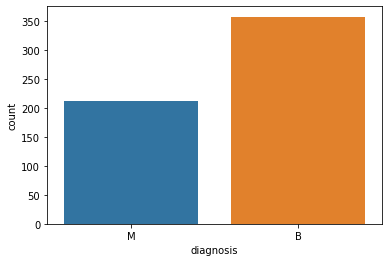

In [51]:
labels = df['diagnosis']
ax = sns.countplot(labels,label="Count")      
benign, malignant = labels.value_counts()
print('Number of Benign: ', benign)
print('Number of Malignant : ', malignant)

Looking at the data, it is apparent we would need some standardization before visualizing it since mean of area_mean is 654 while that of radius_mean is 14 which is too widespread. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

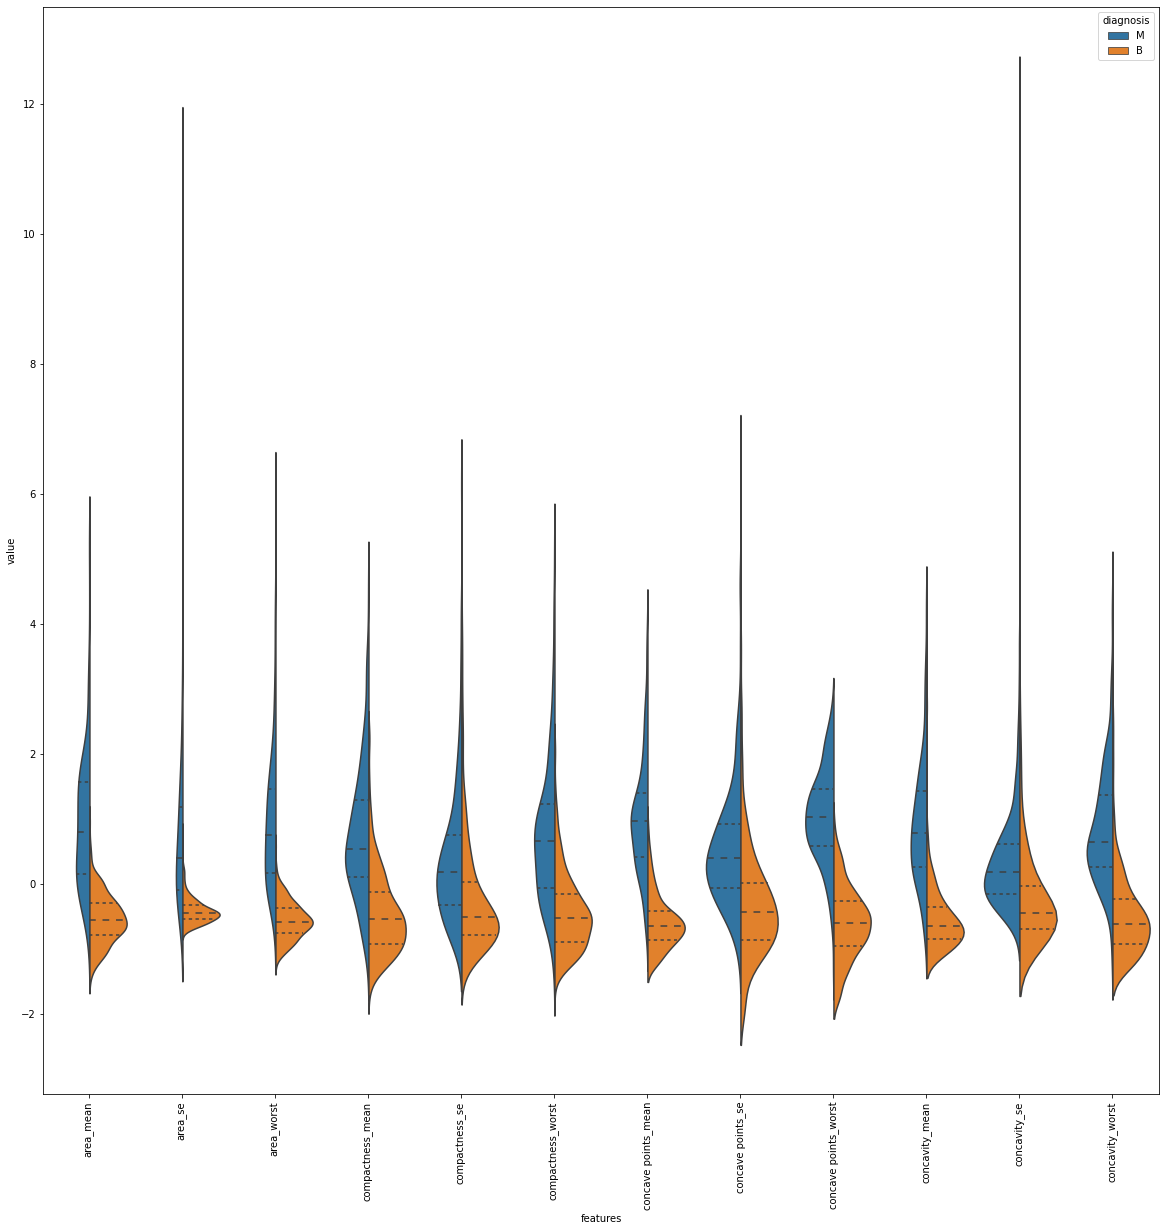

In [52]:
# first ten features
df_sub_features_cal = (df_copy - df_copy.mean()) / (df_copy.std())              # standardization
data_sub_features = pd.concat([labels, df_sub_features_cal.iloc[:,0:12]],axis=1)
data_sub_features = pd.melt(data_sub_features,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(20,20))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data_sub_features, split=True, inner="quart")
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text major ticklabel objects>)

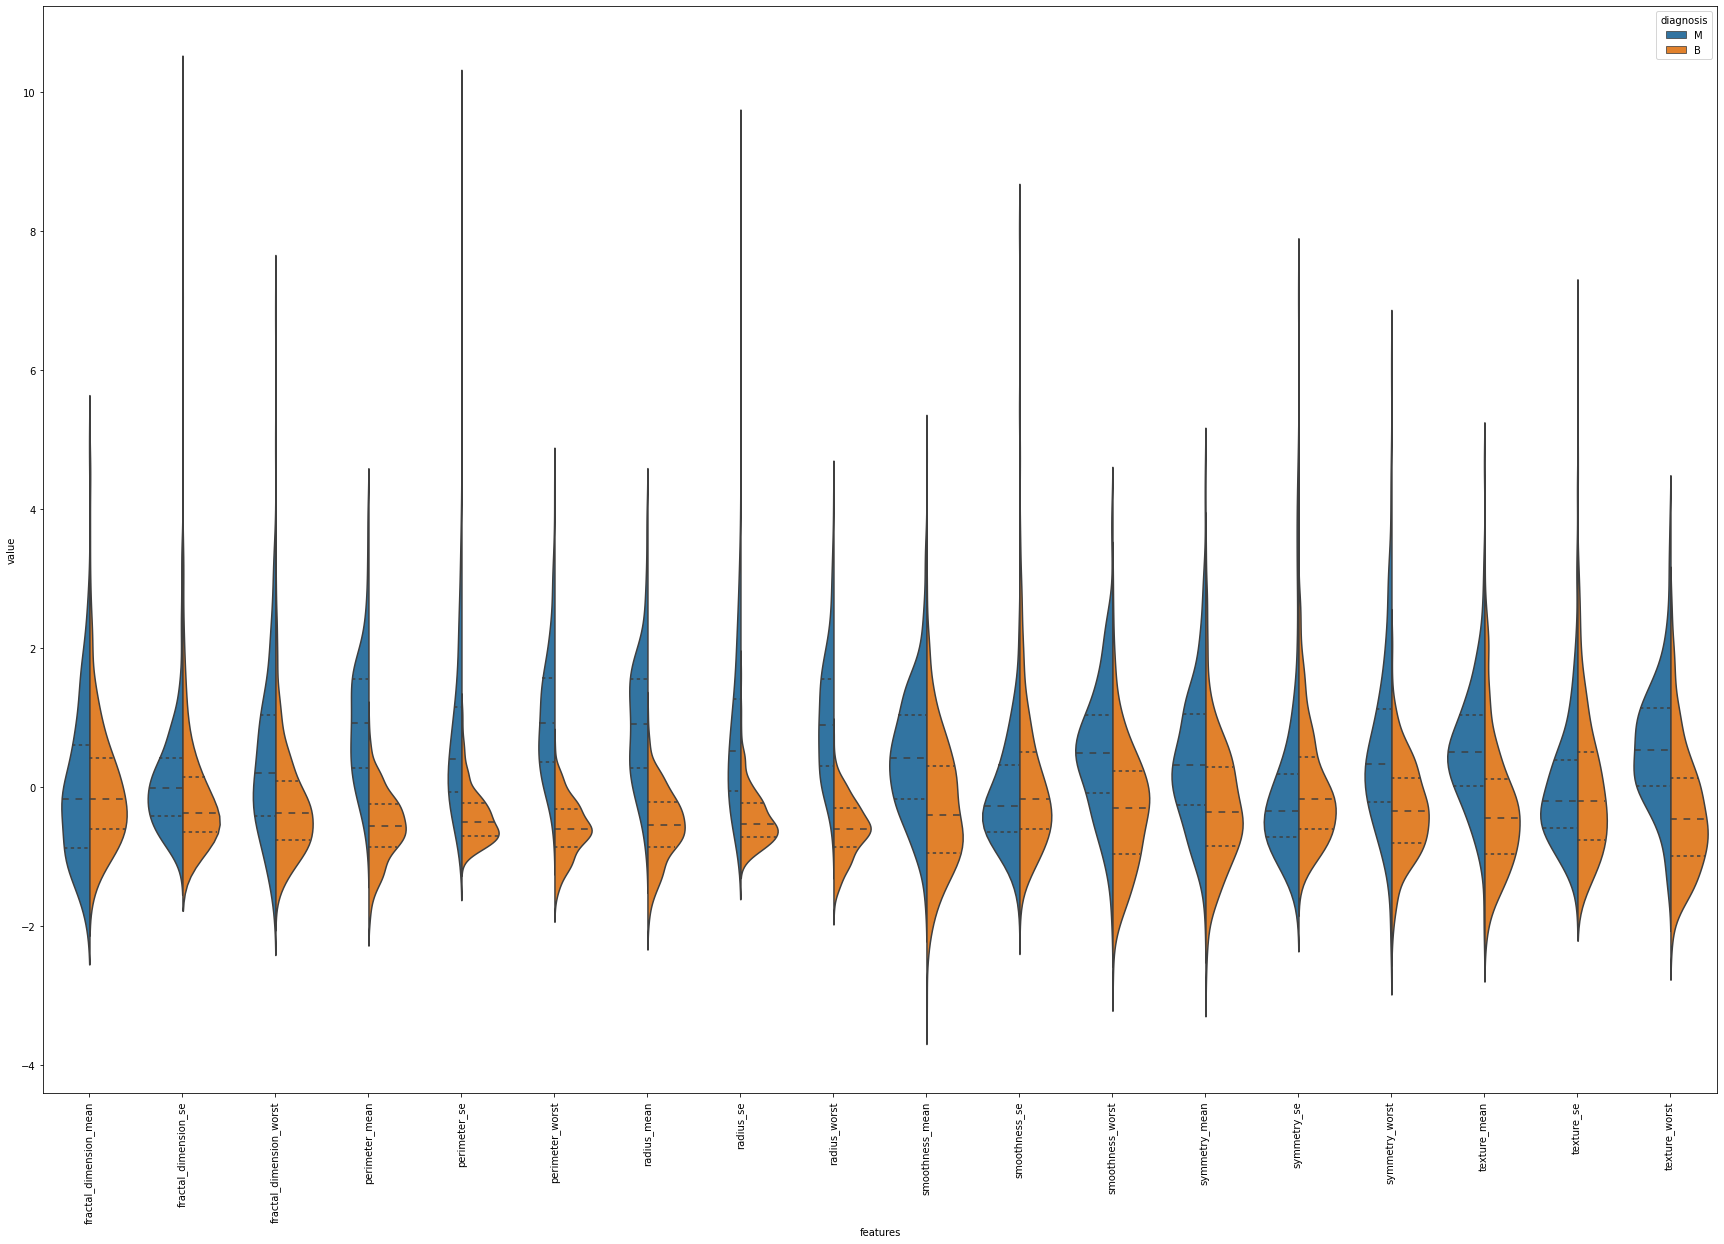

In [53]:
data_sub_features_2 = pd.concat([labels,df_sub_features_cal.iloc[:,13:31]],axis=1)
data_sub_features_2 = pd.melt(data_sub_features_2,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(30,20))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data_sub_features_2, split=True, inner="quart")
plt.xticks(rotation=90)

Shows that the data in area_mean is comparitvely more seperated than concave points_worse which is good for classification. 

Lets interpret one more thing about plot above, how can we decide which features are correlated with each other or not. (Not always true but if the features are correlated with each other we can drop one of them). Seaborn's heatmap can give us great insight about feature correlation. 

**Feature Reduction**

In [54]:
# def binarize_column(input_df, feature_name, row_variable_to_replace, substitute_variable):
#     return input_df[feature_name].replace(row_variable_to_replace, substitute_variable, inplace=True)
  
# def add_(input_df, new_col_label, new_col):
#     input_df[new_col_label] = new_col
#     return
  
# def dropFeature(input_df, drop_col_label):
#     input_df = input_df.drop(drop_col_label, axis=1)
#     return input_df

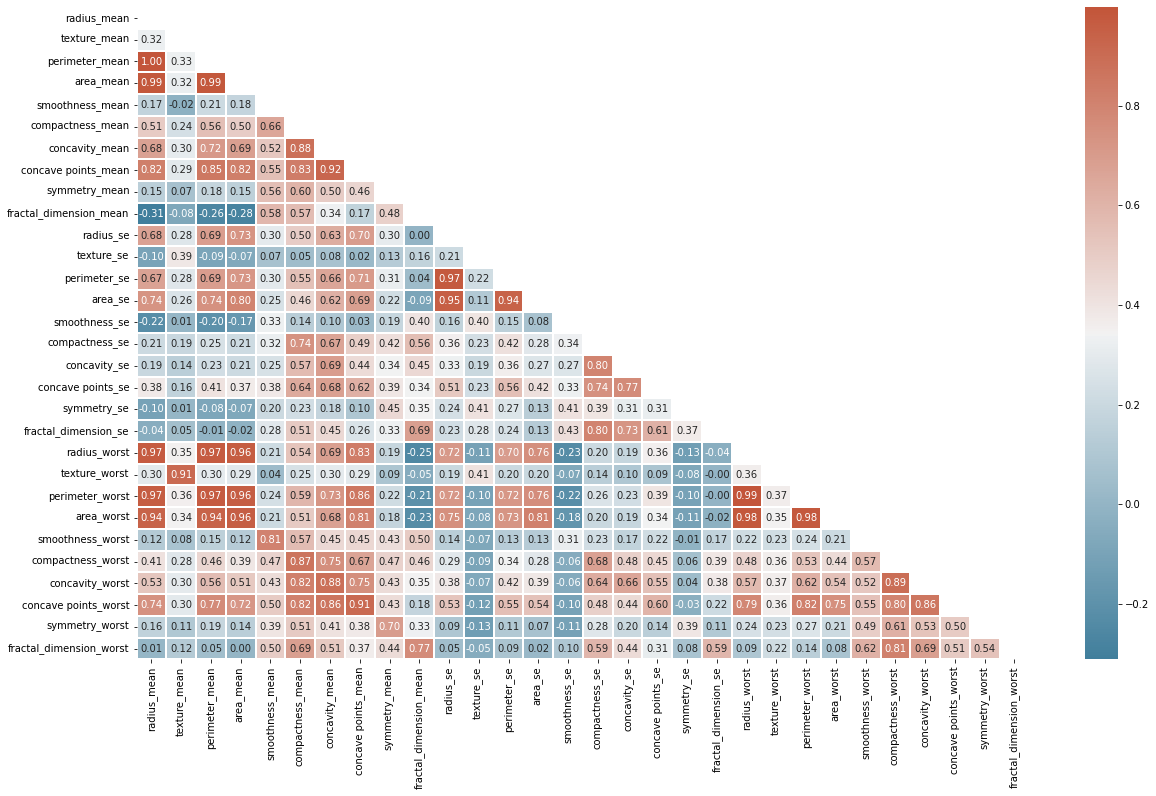

In [55]:
# heatmap 
plt.figure(figsize = (20, 12))

# compute the correlation matrix
corr = df_copy.corr()

# generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype = bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, linewidths = 1, cmap=cmap, annot = True, fmt = ".2f")
plt.show()

In [56]:
def remove_correlated_columns(input_df, threshold):
  corr_matrix = input_df.corr().abs() 
  mask = np.triu(np.ones_like(corr_matrix, dtype = bool))
  tri_df = corr_matrix.mask(mask)
  cols_to_drop = [x for x in tri_df.columns if any(tri_df[x] > 0.90)]
  return input_df.drop(cols_to_drop, axis=1) 

df_reduced = remove_correlated_columns(df_copy, 0.90)
print(f"The reduced dataframe has {df_reduced.shape[1]} columns.")
df_reduced.head()

The reduced dataframe has 21 columns.


,diagnosis,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,compactness_se,concavity_se,...,symmetry_se,fractal_dimension_se,texture_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,0.11840,0.27760,0.2419,0.07871,0.9053,153.40,0.006399,0.04904,0.05373,...,0.03003,0.006193,17.33,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,0.08474,0.07864,0.1812,0.05667,0.7339,74.08,0.005225,0.01308,0.01860,...,0.01389,0.003532,23.41,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,0.10960,0.15990,0.2069,0.05999,0.7869,94.03,0.006150,0.04006,0.03832,...,0.02250,0.004571,25.53,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,0.14250,0.28390,0.2597,0.09744,1.1560,27.23,0.009110,0.07458,0.05661,...,0.05963,0.009208,26.50,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,0.10030,0.13280,0.1809,0.05883,0.7813,94.44,0.011490,0.02461,0.05688,...,0.01756,0.005115,16.67,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


The features which had a correlation value of more than 0.90 were dropped as its difficult to use these features for binary classification because of thier multicolinear nature. 

In [57]:
# Mapping labels to start from 0. 
df_reduced['diagnosis'].replace('B', 0, inplace=True)
df_reduced['diagnosis'].replace('M', 1, inplace=True)
df_reduced = df_reduced.astype(float)

labels = df_reduced[["diagnosis"]]

def normalize_df(input_df):
  col_names = input_df.columns
  scaler = MinMaxScaler() 
  df_scaled = scaler.fit_transform(input_df) 
  return pd.DataFrame(df_scaled, columns=col_names)

df_scaled = normalize_df(df_reduced.drop('diagnosis', axis=1))
df_scaled.head()

,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,texture_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.593753,0.792037,0.686364,0.605518,0.120469,0.273811,0.159296,0.351398,0.135682,0.300625,0.311645,0.183042,0.141525,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,0.289880,0.181768,0.379798,0.141323,0.082589,0.125660,0.119387,0.081323,0.046970,0.253836,0.084539,0.091110,0.303571,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,0.514309,0.431017,0.509596,0.211247,0.094303,0.162922,0.150831,0.283955,0.096768,0.389847,0.205690,0.127006,0.360075,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,0.811321,0.811361,0.776263,1.000000,0.175875,0.038155,0.251453,0.543215,0.142955,0.353665,0.728148,0.287205,0.385928,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,0.430351,0.347893,0.378283,0.186816,0.093065,0.163688,0.332359,0.167918,0.143636,0.357075,0.136179,0.145800,0.123934,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595


**Dimensionality Reduction using PCA & t-SNE**

t-SNE is computationally expensive hence it is recommended to perform an initial reduction in the dimensionality of the input dataset while still preserving most of the important data structure using PCA before implementing t-SNE. We do not require to use PCA before t-SNE for this data but only doing it for learning purposes.

In [58]:
def reduce_by_pca(input_df, n_components):
  pca = PCA(n_components)
  pca_result = pca.fit_transform(input_df)
  print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
  return pd.DataFrame(data = pca_result)

df_PCA = reduce_by_pca(df_scaled, 6)
df_PCA.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']
df_PCA.head()

Explained variation per principal component: [0.48353197 0.14515276 0.08648364 0.07240858 0.05866099 0.0502897 ]


,PC1,PC2,PC3,PC4,PC5,PC6
0,1.121342,0.093997,-0.209159,-0.272188,-0.136037,0.179217
1,0.018996,-0.347336,-0.021938,-0.169724,-0.079580,-0.009966
2,0.566202,-0.214413,-0.017895,-0.164127,-0.148050,0.050450
3,1.562700,0.764067,-0.372075,0.179510,-0.019412,0.391650
4,0.142630,-0.092772,0.009400,-0.336075,-0.157543,-0.182389


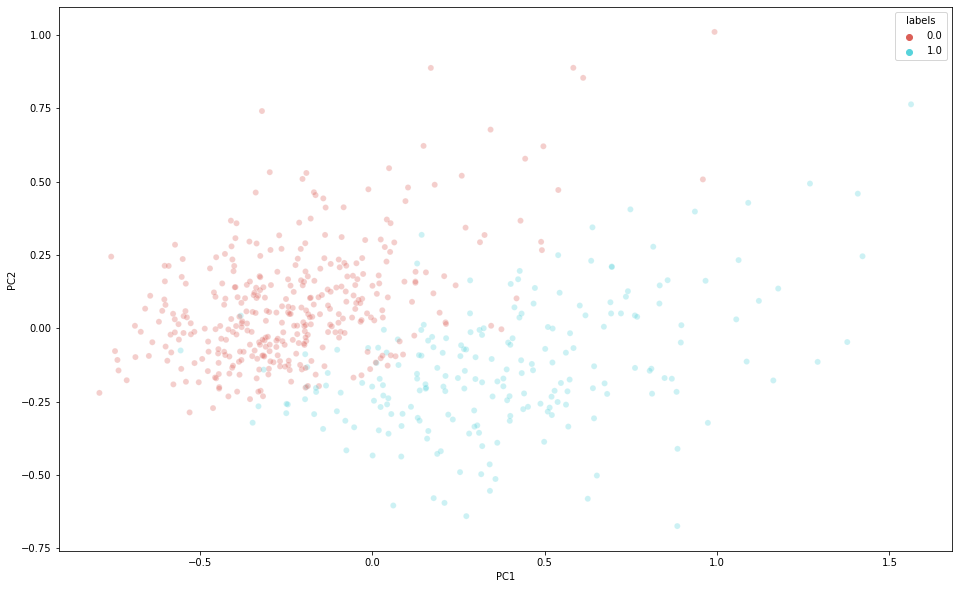

In [59]:
from sklearn.manifold import TSNE
df_PCA["labels"] = labels
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="labels",
    palette=sns.color_palette("hls", 2),
    data=df_PCA,legend="full",alpha=0.3)

In [60]:
import time

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(df_PCA)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.001s...
[t-SNE] Computed neighbors for 569 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 0.161481
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.122021
[t-SNE] KL divergence after 300 iterations: 0.960998


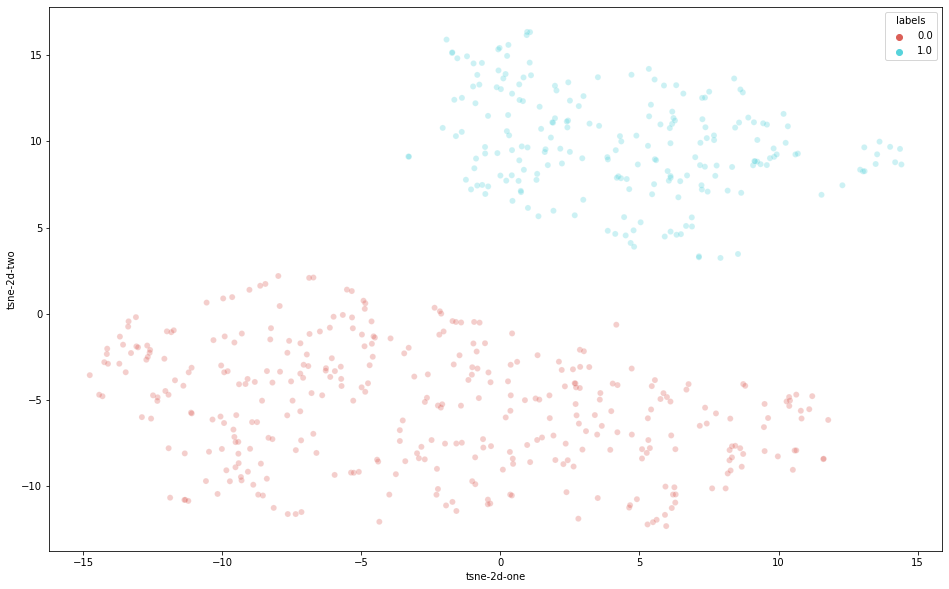

In [61]:
df_PCA["tsne-2d-one"] = tsne_results[:,0]
df_PCA["tsne-2d-two"] = tsne_results[:,1]


plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="labels",
    palette=sns.color_palette("hls", 2),
    data=df_PCA,
    legend="full",
    alpha=0.3
)

We can notice a significant imporovement over PCA visualization we used earlier. We can see that the labels are very clearly clustered in their own sub groups. However, this would be very useful if we were doing a multi class classification. As of now, we will move forward from using PCA to splitting our data into test and train set. 

**Sampling Data**

In [62]:
# Splitting data into test and train 
labels = df_reduced[["diagnosis"]] #redefining labels
x = df_PCA.drop(['tsne-2d-one', 'tsne-2d-two', 'labels'], axis=1)
# Applying Stratified Shuffle Split
data_split = StratifiedShuffleSplit(n_splits=1,test_size=0.25,random_state=0)
data_split.get_n_splits(x, labels)

1

In [63]:
for train_index, test_index in data_split.split(x, labels):
    x_train = x.iloc[train_index]
    y_train = labels.iloc[train_index]
    x_test= x.iloc[test_index]
    y_test= labels.iloc[test_index]
    print(y_train.value_counts())  
    print(y_test.value_counts())

diagnosis
0.0          267
1.0          159
dtype: int64
diagnosis
0.0          90
1.0          53
dtype: int64


If we can establish that the sample data should better reflect the diagnosis then we “stratify” the data. This will involve resampling the sample data so that the we have uuniform distribution of benign vs malignant cases in our test and traning set. If we go ahead and train our model on data which has the wrong proportions it is likely that the model will be over-fitted to the training data and it is also likely that when we run the model against real-world or testing data that is in the right proportions it will underperform.

In [64]:
# Converting DFs to Arrrays

type(np.array(x_train))
type(np.array(y_train))
type(np.array(x_test))
type(np.array(y_test))


numpy.ndarray

The model will be implemented using PyTorch, so the next step is to transform the arrays into a tensors:

In [65]:
def make_data_loader(x, y, batch_size):
  x = torch.tensor(np.array(x), dtype=torch.float)
  y = torch.tensor(np.array(y), dtype = torch.float)
  df_tf = torch.utils.data.TensorDataset(x, y)
  return torch.utils.data.DataLoader(df_tf, batch_size=batch_size, shuffle=True)

# Hyper parameters
num_epochs = 100
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 15

train_loader = make_data_loader(x_train, y_train, batch_size)
test_loader = make_data_loader(x_test, y_test, batch_size)



**Implementing and evaluating the model**

As this is a binary classification task, a binary cross entropy criterion was the choice for training criterion for the neural network. Adam Optimizer was chosen as optimizer as it is a popular choice for deep learning problems because of its simplicity in implementation and low memory requirements. 

In [66]:
def create_model(layer_dims):
    model = torch.nn.Sequential()
    for idx, dim in enumerate(layer_dims):
        if (idx < len(layer_dims) - 1):
            module = torch.nn.Linear(dim, layer_dims[idx + 1])
            init.xavier_normal(module.weight)
            model.add_module("linear" + str(idx), module)
        else:
            model.add_module("sig" + str(idx), torch.nn.Sigmoid())
        if (idx < len(layer_dims) - 2):
            model.add_module("relu" + str(idx), torch.nn.ReLU())

    return model

dim_in = x_train.shape[1]
dim_out = 1
layer_dims = [dim_in, 15, 15, dim_out]
model = create_model(layer_dims)

In [67]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

for epoch in range(num_epochs):
  # To store the error:
  run_loss = 0.

  for inputs, labels in train_loader:
    # inputs, labels = data
    optimizer.zero_grad()
    outputs = model(inputs) 
    error = criterion(outputs, labels)
    error.backward()
    optimizer.step() 

    run_loss += error.item()
  print('Epoch %3d: loss %.5f' % (epoch+1, run_loss/len(train_loader)))

Epoch   1: loss 0.74106
Epoch   2: loss 0.70725
Epoch   3: loss 0.67253
Epoch   4: loss 0.63378
Epoch   5: loss 0.58553
Epoch   6: loss 0.52325
Epoch   7: loss 0.45484
Epoch   8: loss 0.38930
Epoch   9: loss 0.32879
Epoch  10: loss 0.27772
Epoch  11: loss 0.24985
Epoch  12: loss 0.21327
Epoch  13: loss 0.19312
Epoch  14: loss 0.17391
Epoch  15: loss 0.16839
Epoch  16: loss 0.15346
Epoch  17: loss 0.14198
Epoch  18: loss 0.13779
Epoch  19: loss 0.13151
Epoch  20: loss 0.14097
Epoch  21: loss 0.12085
Epoch  22: loss 0.12080
Epoch  23: loss 0.11495
Epoch  24: loss 0.11384
Epoch  25: loss 0.11046
Epoch  26: loss 0.11481
Epoch  27: loss 0.10923
Epoch  28: loss 0.11083
Epoch  29: loss 0.10529
Epoch  30: loss 0.10419
Epoch  31: loss 0.10459
Epoch  32: loss 0.10420
Epoch  33: loss 0.10327
Epoch  34: loss 0.10283
Epoch  35: loss 0.10096
Epoch  36: loss 0.10027
Epoch  37: loss 0.12331
Epoch  38: loss 0.09919
Epoch  39: loss 0.10131
Epoch  40: loss 0.09845
Epoch  41: loss 0.09989
Epoch  42: loss 

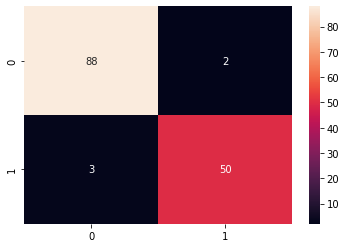

In [68]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
  output = model(inputs)  # Feed Network

  output = (torch.round(output)).detach().numpy()
  y_pred.extend(output) # Save Prediction
  
  labels = labels.detach().numpy()
  y_true.extend(labels) # Save Truth
        

cf_matrix = confusion_matrix(y_true, y_pred)

plt.figure()
sns.heatmap(cf_matrix, annot=True)
plt.savefig('output.png')

The classifier made a total of 143 predictions, from which:



*   88 samples were correctly estimated as benign tumors.
*   50 samples were correctly estimated as malignant tumors.
* 3 samples estimated as false negatives, these should have been classified as malignant tumors but were classified as benign.
* 2 samples were estimated as false positives.









In [69]:
print(classification_report(y_pred, y_true))
print("Accuracy is:", accuracy_score(y_pred, y_true))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97        91
         1.0       0.94      0.96      0.95        52

    accuracy                           0.97       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.97      0.97      0.97       143

Accuracy is: 0.965034965034965


The model had an accuracy of 96.5%. 